In [1]:
"""
Data Exploration Notebook
This is how we explored the data.
"""

'\nData Exploration Notebook\n'

In [2]:
import math

import helper
from analyzer import Analyzer, group_tweets_by_calendar_week
from crawler import Crawler
from plotter import Plotter
from model import Vader, TrainedSentimentModel, TextBlob

# Extra imports
import datetime
import os
import json
import numpy as np

import matplotlib.pyplot as plt
import statistics
import scipy.stats

In [3]:
config_dict = {
	"user_auth": False,  # autheticate as user or application
	"search": {
		"location": "darmstadt",  # based on helper.GEOCODES dictionary
		"radius": 100,  # optional default to 100
		"query": ['der, die, das'],  # query for searching (str array), either query or location has to be not empty
		"max_searches": 5000,  # Default: 1000 max amount of searches
		"num_results": 5000,  # number of results with defined filter options
		"rate_limit": True,  # Default True: to turn off rate limit prints
		"filter": {  # Filter applies to search
			"not_reply": True,  # Filters for not replies when true, does nothing when false
			"not_retweet": True,  # Filters for not retweets when true, does nothing when false
			"until": datetime.datetime(2020, 3, 1),  # None or datetime (e.g. datetime.datetime(2020, 5, 20))
		}
	},
	"get_user": {  # Optional, only when querying for users
		"good_user": True,  # mandatory
		"search_type": "recent_user",  # 'recent_user', 'recent_retweeted_user'
		"num_users": 30,  # mandatory
		"unique_ids": True,  # If true will remember user ids in session
	},
	"analyze_sentiment": {
		"pos_boundary": 0.8,  # boundary for classifying tweets as "extremely" positive
		"neg_boundary": 0.7,  # boundary for classifying tweets as "extremely" negative
		"users_dir": "saved_data/full_scan_both/results/all/"  # there the sentiment analysis files are stored
	},
	"plot": {
		"title": "Testing",
		"group_by": 1,  # number of days of each group in the histogramm
		"end_date": datetime.datetime(2020, 6, 30, 23, 59),  # last day included in the analysis
		"start_date": datetime.datetime(2020, 3, 1)  # first day included in the analysis
	},
	# Full search not tested and should only be used with caution!
	"full_search": {
		"query": "#Corona lang:de",  # the query used for full search
		"env_name": "dev",  # your premium environment name
		"fromDate": "2020" + "01" + "15" + "1200",  # Format: YYYYMMDDHHmm
		"toDate": "2020" + "06" + "01" + "1200"
	},
	# A full scan over 3 areas each hour, should run continuous
	"full_scan": {
		"active": True,
		"path": "saved_data/full_scan/",
		"locations": ["scan_1", "scan_2", "scan_3"],  # All locations used by the scan
	}
}

In [4]:
config = helper.init_config(config_dict)
crawler = Crawler(config)
trained_model = TrainedSentimentModel()
analyzer = Analyzer(config, trained_model)

In [5]:
def get_reduced_tweets(scan_id: int=None, begin_id: int=None, end_id: int=None):
    """
    :param scan_id: Defines the specific id to folder, if None, will take all folders into the output
    """
    analysation_dicts = []
    if scan_id is None:
        all_user_ids = set()
        user_filenames = []
        for i in range(0, 3):
            users_dir = "saved_data/full_scan_both/tweets/{}/".format(i)
            current_user_ids = [user_id for user_id in sorted(os.listdir(users_dir)) if not user_id in all_user_ids]
            all_user_ids.update(current_user_ids)
            # should all be files, just to be extra sure
            current_user_filenames = [users_dir + filename for filename in current_user_ids if
                                      os.path.isfile(users_dir + filename)]
            user_filenames += current_user_filenames
    else:
        assert scan_id in [0,1,2]
        users_dir = "saved_data/full_scan_both/tweets/{}/".format(scan_id)
        user_filenames = [users_dir + filename for filename in sorted(os.listdir(users_dir)) if
                          os.path.isfile(users_dir + filename)]
    
    # If begin/end_id is None, will go to start from 0/until the end
    user_filenames = user_filenames[begin_id: end_id]
    user_tweets = [crawler.load_tweet_for_analysation(filename) for filename in user_filenames]
    return user_tweets

def get_sentiment(user_tweets):
    per_user_analysation = analyzer.analyze_sentiment_user_based(user_tweets)
    return per_user_analysation

In [6]:
# Load all tweets
user_tweets = get_reduced_tweets()
# Load all sentiments
user_senti = get_sentiment(user_tweets)

Dropped 382 Users because no id found!


In [37]:
def per_user_senti_ratios(user):
    neg_amount = 0
    pos_amount = 0
    neut_amount = 0
    for week_id, senti_dict in user.items():
        # print(week_id, senti_dict)
        if senti_dict["neut_amount"] != -1:
            neg_amount += senti_dict["extremely_neg_amount"]
            pos_amount += senti_dict["extremely_pos_amount"]
            neut_amount += senti_dict["neut_amount"]
    overall_amount = neg_amount + pos_amount + neut_amount
    if overall_amount == 0:
        return 0, 0, 0, 0, 0, 0
    neg_perc = neg_amount / overall_amount
    pos_perc = pos_amount / overall_amount
    neut_perc = neut_amount / overall_amount
    return neg_amount, neut_amount, pos_amount, neg_perc, neut_perc, pos_perc

print(per_user_senti_ratios(user_senti[3]))
# print(user_senti[0]["01.03"]["extremely_neg_amount"])

(8, 308, 59, 0.021333333333333333, 0.8213333333333334, 0.15733333333333333)


61


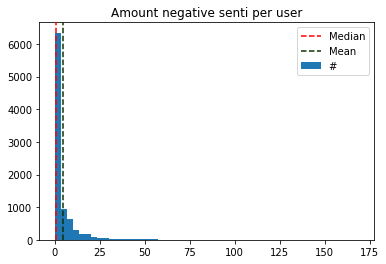

Amount Values:  9002
Mean:  4.575872028438125
Median:  1.0
Highest:  169.0
Lowest:  0.0


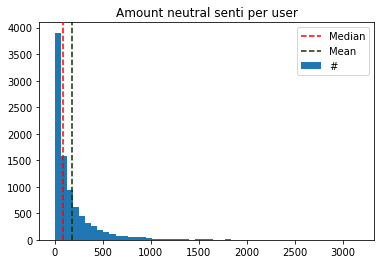

Amount Values:  9002
Mean:  183.1825149966674
Median:  83.0
Highest:  3169.0
Lowest:  0.0


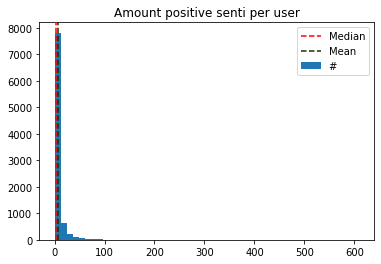

Amount Values:  9002
Mean:  6.755832037325039
Median:  2.0
Highest:  609.0
Lowest:  0.0


In [39]:
amounts = []
count = 0
for user in user_senti:
    res = per_user_senti_ratios(user)
    if sum(res) == 0:
        count += 1
    amounts.append(res)
print("Empty users?", count)
hist_analysis(np.array(amounts)[:,0], bins=50, title="Amount negative senti per user")
hist_analysis(np.array(amounts)[:,1], bins=50, title="Amount neutral senti per user")
hist_analysis(np.array(amounts)[:,2], bins=50, title="Amount positive senti per user")


In [41]:
amounts = np.array(amounts)
print("Overall amount neg senti: ", sum(amounts[:,0]))
print("Overall amount neut senti: ", sum(amounts[:,1]))
print("Overall amount pos senti: ", sum(amounts[:,2]))

Overall amount neg senti:  41192.0
Overall amount neut senti:  1649009.0
Overall amount pos senti:  60816.0


In [9]:
def summarize_user_sentiments(user_analysations):
    """Given a list of user_analysations (dicts containing the percentage of pos/neg tweets per timespan for each user)
    return only one similar dict containing the means of those percentages per timespan"""
    overall_analysation = {group_id: {} for group_id, week_evaluation in user_analysations[0].items()}
    for group_id in user_analysations[0]:
        # PERCENTAGES
        try:
            overall_analysation[group_id]["extremely_pos_percentage"] = \
                statistics.mean((user_dict[group_id]["extremely_pos_percentage"] for user_dict in user_analysations
                                 if not user_dict[group_id]["extremely_pos_percentage"] == -1))
        except statistics.StatisticsError:
            overall_analysation[group_id]["extremely_pos_percentage"] = 0
            print("No pos datapoints for this timespan, start_date = {}".format(group_id))
        try:
            overall_analysation[group_id]["extremely_neg_percentage"] = \
                statistics.mean((user_dict[group_id]["extremely_neg_percentage"] for user_dict in user_analysations
                                 if not user_dict[group_id]["extremely_neg_percentage"] == -1))
        except statistics.StatisticsError:
            overall_analysation[group_id]["extremely_neg_percentage"] = 0
            print("No neg datapoints for this timespan, start_date = {}".format(group_id))
        
        # AMOUNTS MEAN
        try:
            overall_analysation[group_id]["extremely_pos_amount_mean"] = \
                statistics.mean((user_dict[group_id]["extremely_pos_amount"] for user_dict in user_analysations
                                 if not user_dict[group_id]["extremely_pos_amount"] == -1))
        except statistics.StatisticsError:
            overall_analysation[group_id]["extremely_pos_amount_mean"] = 0
            print("No pos datapoints for this timespan, start_date = {}".format(group_id))
        try:
            overall_analysation[group_id]["extremely_neg_amount_mean"] = \
                statistics.mean((user_dict[group_id]["extremely_neg_amount"] for user_dict in user_analysations
                                 if not user_dict[group_id]["extremely_neg_amount"] == -1))
        except statistics.StatisticsError:
            overall_analysation[group_id]["extremely_neg_amount_mean"] = 0
            print("No neg datapoints for this timespan, start_date = {}".format(group_id))
            
        # AMOUNTS SUM
        try:
            overall_analysation[group_id]["extremely_pos_amount_sum"] = \
                    sum((user_dict[group_id]["extremely_pos_amount"] for user_dict in user_analysations
                                 if not user_dict[group_id]["extremely_pos_amount"] == -1))
        except statistics.StatisticsError:
            overall_analysation[group_id]["extremely_pos_amount_sum"] = 0
            print("No pos datapoints for this timespan, start_date = {}".format(group_id))
        try:
            overall_analysation[group_id]["extremely_neg_amount_sum"] = \
                    sum((user_dict[group_id]["extremely_neg_amount"] for user_dict in user_analysations
                                 if not user_dict[group_id]["extremely_neg_amount"] == -1))
        except statistics.StatisticsError:
            overall_analysation[group_id]["extremely_neg_amount_sum"] = 0
            print("No neg datapoints for this timespan, start_date = {}".format(group_id))
        try:
            overall_analysation[group_id]["neut_amount_sum"] = \
                    sum((user_dict[group_id]["neut_amount"] for user_dict in user_analysations
                                 if not user_dict[group_id]["neut_amount"] == -1))
        except statistics.StatisticsError:
            overall_analysation[group_id]["neut_amount"] = 0
            print("No neg datapoints for this timespan, start_date = {}".format(group_id))
    return overall_analysation

In [10]:
sumar = summarize_user_sentiments(user_senti)

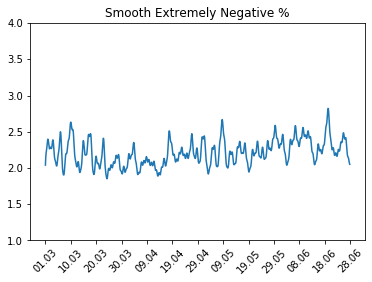

AssertionError: 

In [19]:
def plot_senti(plot_arr, title):
    day_ticks = ["01.03", "10.03", "20.03", "30.03", "09.04", "19.04", "29.04", "09.05", "19.05", "29.05",
                 "08.06", "18.06", "28.06"]
    plt.xticks(np.arange(0,122,10), day_ticks, rotation=45)
    # plt.plot(plot_arr)
    plt.bar(range(len(plot_arr)), plot_arr)
    plt.title(title)
    plt.savefig(title + ".png")
    plt.show()

def get_gaus_dist(value_arr, amount):
    sigma = 0.5
    x_vals = []
    # 122 for all days
    for x in np.linspace(0, 123, amount):
        res = 0 
        for idx, value in enumerate(value_arr):
            res += scipy.stats.norm.pdf(x, idx, sigma) * value
        x_vals.append(res)
    return x_vals

def plot_gaus(pos_dict, title):
    amount = 1000
    plt.plot(get_gaus_dist(pos_dict, amount)[:-20])
    plt.title(title)
    day_ticks = ["01.03", "10.03", "20.03", "30.03", "09.04", "19.04", "29.04", "09.05", "19.05", "29.05",
                 "08.06", "18.06", "28.06"]
    plt.xticks(np.linspace(0, amount-20, 13), day_ticks, rotation=45)
    plt.ylim(1, 4)
    plt.savefig(title + ".png")
    plt.show()
    
def get_pos_dict(summ_arr, str_key):
    return [info[str_key] for week, info in summ_arr.items()]

# summed_dict = np.array(get_pos_dict(sumar, "extremely_neg_amount_sum")) + np.array(get_pos_dict(sumar, "extremely_pos_amount_sum")) + np.array(get_pos_dict(sumar, "neut_amount_sum"))
# plot_senti(summed_dict, "Summed Amount of Tweets per Day")

 #pos_dict = get_pos_dict(sumar, "extremely_pos_percentage")
# plot_gaus(pos_dict, "Smooth Extremely Positive %")
# plot_senti(pos_dict, "Extremely Positive %")
pos_dict = get_pos_dict(sumar, "extremely_neg_percentage")
plot_gaus(pos_dict, "Smooth Extremely Negative %")
# plot_senti(pos_dict, "Extremely Positive %")
# assert False

plt.plot(get_gaus_dist(pos_dict, 100))
plt.title("Smooth Extremely Positive %")
plt.savefig("gaus_extremely_pos_percentage" + ".png")
plt.show()

pos_dict = get_pos_dict(sumar, "extremely_neg_percentage")
plot_senti(pos_dict, "Extremely Negative %")

pos_dict = get_pos_dict(sumar, "extremely_neg_amount_sum")
plot_senti(pos_dict, "Extremely Negative Amount Summed")
plt.plot(get_gaus_dist(pos_dict, 100))
plt.title("Smooth Extremely Negative Amount Summed")
# plt.savefig("gaus_extremely_neg_amount_sum" + ".png")
plt.show()

pos_dict = get_pos_dict(sumar, "extremely_pos_amount_sum")
plot_senti(pos_dict, "Extremely Positive Amount Summed")
plt.plot(get_gaus_dist(pos_dict, 100))
plt.title("Smooth Extremely Positive Amount Summed")
plt.savefig("gaus_extremely_pos_amount_sum" + ".png")
plt.show()

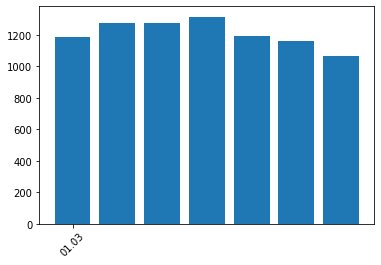

In [56]:
str_key = "extremely_neg_amount_sum"
week1 = np.array([info[str_key] for week, info in sumar.items() if int(week[0:2]) in range(2,9) and week[-1] == "3"])
week2 = np.array([info[str_key] for week, info in sumar.items() if int(week[0:2]) in range(9,16) and week[-1] == "3"])
week3 = np.array([info[str_key] for week, info in sumar.items() if int(week[0:2]) in range(16,23) and week[-1] == "3"])
week4 = np.array([info[str_key] for week, info in sumar.items() if int(week[0:2]) in range(23,30) and week[-1] == "3"])
all_weeks = week1 + week2 + week3 + week4
# pos_dict = get_pos_dict(sumar, "extremely_neg_amount_sum")
# print(np.shape(pos_dict))
plot_senti(all_weeks)

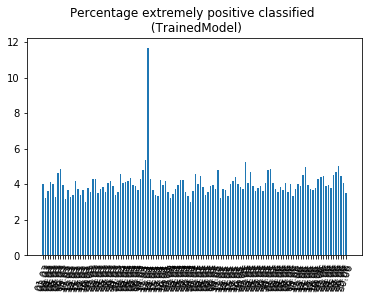

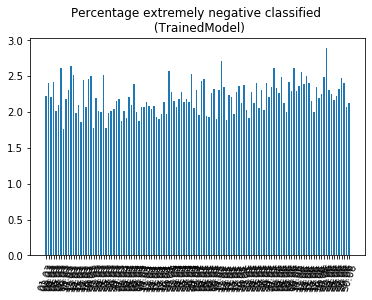

In [34]:
sumar = analyzer.summarize_user_sentiments(user_senti)
analyzer.plot_sentiment(sumar)

In [8]:
# user_tweets -> List of users, per user a list of ReducedStatus, per ReducedStatus, user_id, text, created_at
print(type(user_tweets[0]))
print(len(user_tweets[0]))

num_tweets_per_user = [len(timeline) for timeline in user_tweets]
print("Amount of users with > 1000 tweets:", len([number for number in num_tweets_per_user if number == 0]))
print("Amount of users with < 100 tweets:", len([number for number in num_tweets_per_user if number < 100]))


<class 'list'>
597
Amount of users with > 1000 tweets: 382
Amount of users with < 100 tweets: 5065


In [10]:
def hist_analysis(values, bins=50, title="", time=False, **args):
    # Pass additional args for hist via **args
    plt.hist(values, bins=bins, label='#', zorder=1, **args)
    plt.title(title)
    plt.axvline(statistics.median(values), label='Median', linestyle='--', color="r", zorder=3)
    plt.axvline(statistics.mean(values), label='Mean', linestyle='--', color="#103000", zorder=4)
    if time:
        # Set x labels as hours in the day
        plt.xticks(np.arange(12)*120, [str(x*2) for x in np.arange(12)])
    plt.legend()
    plt.savefig(title + ".png")
    plt.show()
    print("Amount Values: ",  len(values))
    print("Mean: ", statistics.mean(values))
    print("Median: ", statistics.median(values))
    print("Highest: ", max(values))
    print("Lowest: ", min(values))

Number of Tweets: 1809681


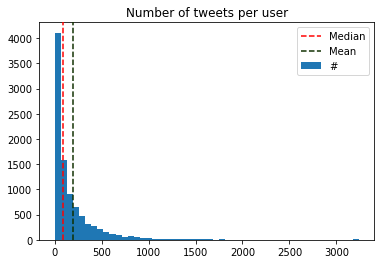

Amount Values:  9384
Mean:  192.8475063938619
Median:  84.5
Highest:  3241
Lowest:  0


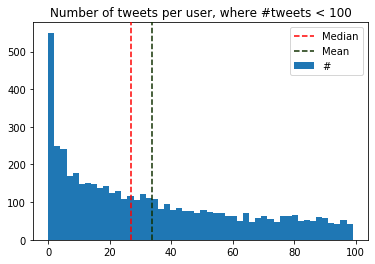

Amount Values:  5065
Mean:  33.58420533070089
Median:  27
Highest:  99
Lowest:  0


In [47]:
# Number of tweets per user Analysis
num_tweets_per_user = [len(timeline) for timeline in user_tweets]
print("Number of Tweets:", sum(num_tweets_per_user))
hist_analysis(num_tweets_per_user, title="Number of tweets per user")

num_tweets_sub_100 = [number for number in num_tweets_per_user if number < 100]
hist_analysis(num_tweets_sub_100, title="Number of tweets per user, where #tweets < 100")

# I think there was a problem-ish in the code for checking:
# In good user: if len(days_until) > 0 and days_until[0] > 7: return False
# Would not return false if len(days_until) == 0, so I think this is why users without tweet actions came through...

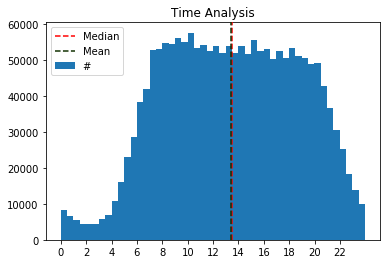

Amount Values:  1809681
Mean:  806.9817929237253
Median:  808
Highest:  1439
Lowest:  0


In [11]:
# Time analysis:
min_passed_all_users = []
for cur_user in user_tweets:
    # Distribution over minutes after 00:00
    min_passed_all_users += [tweet.created_at.hour * 60 + tweet.created_at.minute for tweet in cur_user]

hist_analysis(min_passed_all_users, bins=48, time=True, title="Time Analysis")

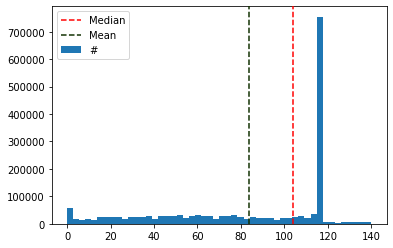

Amount Values:  1809681
Mean:  83.64268177651199
Median:  104
Highest:  140
Lowest:  0


In [49]:
# Twitters max char lenght is 140, but will be cut to 117 if tweet is too long. So can be values between 140 and 117.
# Lowest 0 -> Video or so ...
# Tweets above lenght 140 are chars that are saved weird, e.g. &gt; is > or &lt; is <
# veeeery manual preprocessing, to replace <, >, &
text_lenghts = []
for user in user_tweets:
    lenghts = [len(tweet.text.split("https")[0].replace("&gt;", ">").replace("&lt;", "<").replace("&amp;", "&")) for tweet in user]
    for idx, ln in enumerate(lenghts):
        if ln > 140:
            print(ln, user[idx].text.split("https")[0])
    text_lenghts += lenghts
hist_analysis(text_lenghts, bins=50)

In [56]:
print("Amount of tweets without text: ", sum([1 for length in text_lenghts if length > 117]))

Amount of tweets without text:  40275
